In [257]:
import numpy as np
import pandas as pd
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

## Feature Selection ##

In [442]:
# Handle missing values and ensure that all relevant features are properly scaled.

# Read in the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Drop id columns
X_train = train.drop(columns=['Exited', 'Surname', 'CustomerId', 'id'])
y_train = train['Exited']
X_test = test.drop(columns=['Surname', 'CustomerId', 'id'])

# Handle missing values by filling with mean for numerical features and most frequent for categorical
train = train.fillna(train.mean(numeric_only=True))
test = test.fillna(test.mean(numeric_only=True))

# Fill categorical missing values (if any)
for col in ['Geography', 'Gender']:
    train[col] = train[col].fillna(train[col].mode()[0])
    test[col] = test[col].fillna(test[col].mode()[0])

# Define the column transformation pipeline
numerical_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns
    
# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  # Scaling numerical features
        ('cat', OneHotEncoder(), categorical_cols)  # One-hot encoding categorical features
    ]
)

# Preprocess the data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Get feature names for numerical and one-hot encoded categorical columns
ohe_categories = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
feature_names = list(numerical_cols) + list(ohe_categories)

# Convert preprocessed data back into DataFrame
X_train_df = pd.DataFrame(X_train_preprocessed, columns=feature_names, index=X_train.index)
X_test_df = pd.DataFrame(X_test_preprocessed, columns=feature_names, index=X_test.index)

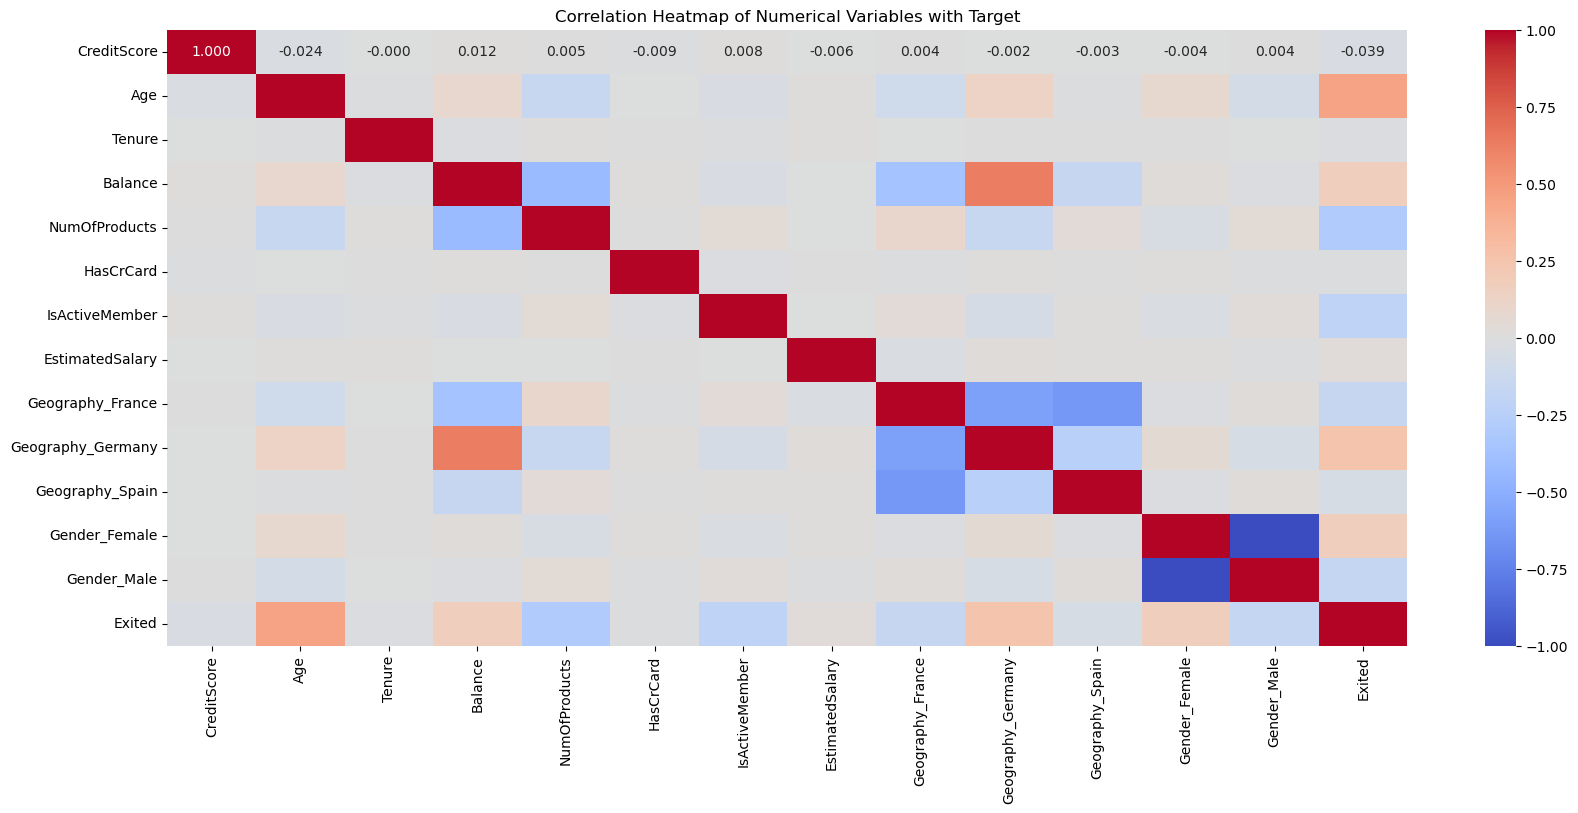

In [444]:
#Analyze categorical and numerical variables to determine which are most important for churn prediction.

# Compute correlation matrix
corr_matrix = pd.concat([X_train_df, y_train], axis=1).corr()

# Plot heatmap of correlation matrix
plt.figure(figsize=(20, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.3f')
plt.title('Correlation Heatmap of Numerical Variables with Target')
plt.show()

In [447]:
# Correlation-Based Feature Selection (For Numerical Features):
# Compute correlation matrix
corr_matrix = X_train_df.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))  # Replace np.bool with bool

# Find features with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

# Drop the highly correlated features
X_train_df.drop(columns=to_drop, inplace=True)
X_test_df.drop(columns=to_drop, inplace=True)

print(f"Dropped features: {to_drop}")

Dropped features: []


In [449]:
# Using Model-Based Feature Importance
# Train a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_df, y_train)

# Get feature importances
importance = rf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train_df.columns, 'Importance': importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display feature importances
print(feature_importance_df)

              Feature  Importance
1                 Age    0.306109
4       NumOfProducts    0.162351
7     EstimatedSalary    0.125134
0         CreditScore    0.119449
3             Balance    0.091495
2              Tenure    0.069479
6      IsActiveMember    0.043150
9   Geography_Germany    0.027881
5           HasCrCard    0.013359
12        Gender_Male    0.013043
11      Gender_Female    0.011083
8    Geography_France    0.010458
10    Geography_Spain    0.007010


## Preprocessing Data ##

In [549]:
# Handle missing values and ensure that all relevant features are properly scaled.
def preprocess_data(train_path, test_path):
    # Load data
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)

    # Drop unnecessary columns
    X_train = train_data.drop(columns=['Exited', 'Surname', 'CustomerId', 'id'])
    y_train = train_data['Exited']
    X_test = test_data.drop(columns=['Surname', 'CustomerId', 'id'])

    # Scale numerical features
    scaler = StandardScaler()
    numerical_cols = X_train.select_dtypes(include=['float64', 'int64']).columns

    X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
    X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

    # One-hot encode categorical columns
    encoder = OneHotEncoder(drop='first', sparse_output=False)  # Drop first to avoid multicollinearity
    categorical_cols = X_train.select_dtypes(include=['object']).columns

    # Transform categorical features and convert back to DataFrame
    X_train_encoded = pd.DataFrame(encoder.fit_transform(X_train[categorical_cols]), 
                                   columns=encoder.get_feature_names_out(categorical_cols), 
                                   index=X_train.index)
    X_test_encoded = pd.DataFrame(encoder.transform(X_test[categorical_cols]), 
                                  columns=encoder.get_feature_names_out(categorical_cols), 
                                  index=X_test.index)

    # Drop the original categorical columns and concatenate the encoded ones
    X_train = X_train.drop(columns=categorical_cols).join(X_train_encoded)
    X_test = X_test.drop(columns=categorical_cols).join(X_test_encoded)

    # Fill in empty columns
    X_train.fillna(X_train.mean(numeric_only=True), inplace=True)
    X_test.fillna(X_test.mean(numeric_only=True), inplace=True)

    # Keep only top 10 important columns
    #columns_to_keep = [
    #    'Age', 'NumOfProducts', 'EstimatedSalary', 'CreditScore', 'Balance',
    #    'Tenure', 'IsActiveMember', 'Geography_Germany', 'HasCrCard', 
    #    'Gender_Male'
    #]
    
    #X_train = X_train[columns_to_keep]
    #X_test = X_test[columns_to_keep]

    # Convert to float32 for efficient numerical processing
    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)

    return X_train, y_train, X_test

In [551]:
X, y, X_test = preprocess_data('train.csv', 'test.csv')

## Model Building ##

In [554]:
# Define the KNN class
class KNN:

    def __init__(self, k=3, distance_metric='euclidean'):
        """
        k: number of neighbors to consider
        distance_metric: 'euclidean', 'manhattan'
        """
        self.k = k
        self.distance_metric = distance_metric

    def fit(self, X, y):
        """
        Store the training data.
        X: training features, y: training labels (Exited or not)
        """
        self.X_train = np.array(X, dtype=np.float32)  # Ensure X is a NumPy array
        self.y_train = np.array(y, dtype=np.float32)  # Ensure y is a NumPy array

    def compute_distance(self, x):
        """
        Compute the distance between a test point x and all training points.
        """
        if self.distance_metric == 'euclidean':
            return np.linalg.norm(self.X_train - x, axis=1)
        elif self.distance_metric == 'manhattan':
            return np.sum(np.abs(self.X_train - x), axis=1)
        else:
            raise ValueError(f"Unsupported distance metric: {self.distance_metric}")

    def predict(self, X):
        """
        Predict the probability that customers will exit the bank for the given test set X.
        Output is a probability between 0 and 1, representing the likelihood of exiting.
        """
        X = np.array(X, dtype=np.float32)  # Ensure X is a NumPy array

        probabilities = []
        for x in X:  # Process each test point individually
            distances = self.compute_distance(x)

            # Find k nearest neighbors
            k_indices = np.argsort(distances)[:self.k]

            # Get the labels of the k nearest neighbors
            k_nearest_labels = [self.y_train[i] for i in k_indices]

            # Calculate the probability as the proportion of 1's (exited) among the k neighbors
            prob = np.mean(k_nearest_labels)
            probabilities.append(prob)

        return np.array(probabilities)

In [556]:
# Define function for cross-validation
def cross_validate(X, y, knn, n_splits=5):
    """
    Perform K-Fold cross-validation on the KNN model.
    
    Parameters:
    - X: Input features (DataFrame or NumPy array).
    - y: Labels (Series or NumPy array).
    - knn: KNN model instance (already initialized).
    - n_splits: Number of folds for cross-validation.
    
    Returns:
    - Average ROC AUC score across all folds.
    """
    X = np.array(X)
    y = np.array(y)
    
    # Initialize KFold cross-validator
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # List to store AUC scores for each fold
    auc_scores = []

    # Perform K-Fold cross-validation
    for train_index, test_index in kf.split(X):
        # Split the data into training and test sets for this fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Train the KNN model on the training set
        knn.fit(X_train, y_train)

        # Predict probabilities for the test set
        y_prob = knn.predict(X_test)

        # Calculate the ROC AUC score
        auc_score = roc_auc_score(y_test, y_prob)
        auc_scores.append(auc_score)

    # Return the average ROC AUC score across all folds
    avg_auc = np.mean(auc_scores)
    return avg_auc

## Finding Optimal Hyperparameter and K ##

ROC-AUC: 0.7386 | k=1, metric=euclidean
ROC-AUC: 0.7358 | k=1, metric=manhattan
ROC-AUC: 0.7975 | k=2, metric=euclidean
ROC-AUC: 0.8103 | k=2, metric=manhattan
ROC-AUC: 0.8387 | k=3, metric=euclidean
ROC-AUC: 0.8404 | k=3, metric=manhattan
ROC-AUC: 0.8578 | k=4, metric=euclidean
ROC-AUC: 0.8578 | k=4, metric=manhattan
ROC-AUC: 0.8719 | k=5, metric=euclidean
ROC-AUC: 0.8686 | k=5, metric=manhattan
ROC-AUC: 0.8757 | k=6, metric=euclidean
ROC-AUC: 0.8763 | k=6, metric=manhattan
ROC-AUC: 0.8833 | k=7, metric=euclidean
ROC-AUC: 0.8827 | k=7, metric=manhattan
ROC-AUC: 0.8836 | k=8, metric=euclidean
ROC-AUC: 0.8851 | k=8, metric=manhattan
ROC-AUC: 0.8854 | k=9, metric=euclidean
ROC-AUC: 0.8883 | k=9, metric=manhattan
ROC-AUC: 0.8883 | k=10, metric=euclidean
ROC-AUC: 0.8914 | k=10, metric=manhattan
ROC-AUC: 0.8887 | k=11, metric=euclidean
ROC-AUC: 0.8952 | k=11, metric=manhattan
ROC-AUC: 0.8919 | k=12, metric=euclidean
ROC-AUC: 0.8998 | k=12, metric=manhattan
ROC-AUC: 0.8937 | k=13, metric=euc

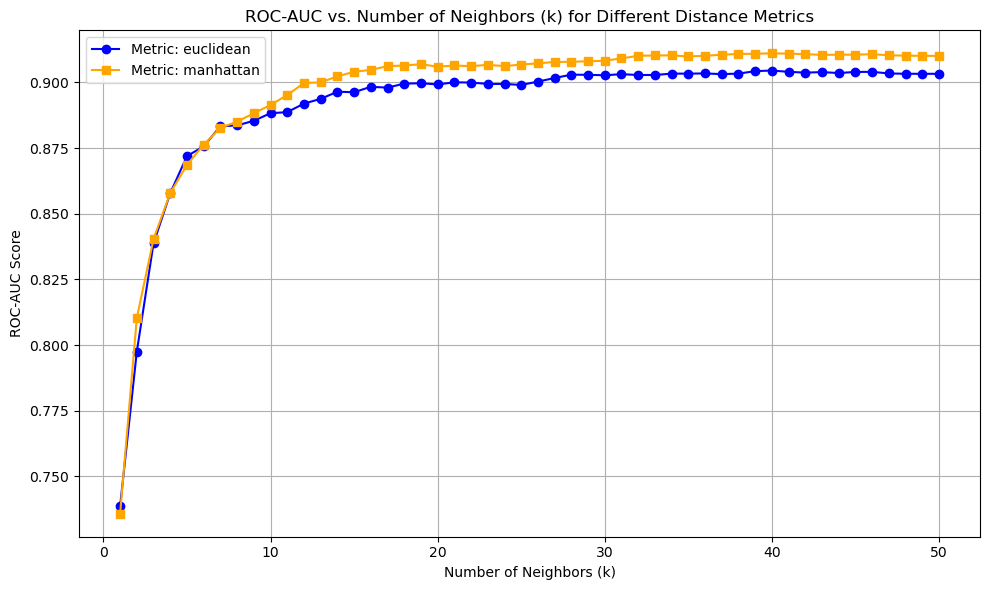

In [560]:
# Load and preprocess data
X_split, _, y_split, _ = train_test_split(X, y, test_size=0.8, random_state=42)

# Define the hyperparameter ranges for k (number of neighbors) and distance metrics
n_neighbors_values = range(1, 51)  # Testing for neighbors from 1 to 50
distance_metrics = ['euclidean', 'manhattan']  # Distance metrics to try

# Store results
results = []

# Loop through different values of k and distance metrics
for n_neighbors in n_neighbors_values:
    for metric in distance_metrics:
        knn = KNN(k=n_neighbors, distance_metric=metric)

        # Perform 5-fold cross-validation using the pre-defined cross_validate function
        mean_auc_score = cross_validate(X_split, y_split, knn, n_splits=5)

        # Store the results
        results.append({
            'n_neighbors': n_neighbors,
            'distance_metric': metric,
            'mean_auc_score': mean_auc_score,
        })

        # Print the results for the current hyperparameter combination
        print(f'ROC-AUC: {mean_auc_score:.4f} | k={n_neighbors}, metric={metric}')
            
# Find the best hyperparameter combination based on ROC AUC score
best_result = max(results, key=lambda x: x['mean_auc_score'])
best_k = best_result['n_neighbors']
best_metric = best_result['distance_metric']
best_auc = best_result['mean_auc_score']

print(f'\nBest k: {best_k} | Best Distance Metric: {best_metric} | Best ROC-AUC: {best_auc:.4f}')

# Plot AUC scores for different values of k and distance metrics
plt.figure(figsize=(10, 6))

# Marker styles and colors for better differentiation
markers = {'euclidean': 'o', 'manhattan': 's'}
colors = {'euclidean': 'blue', 'manhattan': 'orange'}

for metric in distance_metrics:
    k_vals = [res['n_neighbors'] for res in results if res['distance_metric'] == metric]
    auc_vals = [res['mean_auc_score'] for res in results if res['distance_metric'] == metric]
    plt.plot(k_vals, auc_vals, marker=markers[metric], color=colors[metric], 
                linestyle='-', label=f'Metric: {metric}', markersize=6)

plt.xlabel('Number of Neighbors (k)')
plt.ylabel('ROC-AUC Score')
plt.title('ROC-AUC vs. Number of Neighbors (k) for Different Distance Metrics')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Model Evaluation ##

In [563]:
# Create and evaluate model
knn = KNN(k=40, distance_metric='manhattan')

# Perform cross-validation (only ROC-AUC returned)
cv_auc_score = cross_validate(X_split, y_split, knn)

# Train the model on the full split data
knn.fit(X_split, y_split)

# Get predictions on the same data for additional metrics
y_pred = knn.predict(X_split)

# Print all the results
print("Cross-validation AUC:", cv_auc_score)

Cross-validation AUC: 0.9110629848680343


In [564]:
# Create and evaluate model
knn = KNN(k=40, distance_metric='manhattan')

# Perform cross-validation
cv_scores = cross_validate(X, y, knn)

print("Cross-validation scores:", cv_scores)

knn.fit(X, y)
test_predictions = knn.predict(X_test)

# Save test predictions
pd.DataFrame({'id': pd.read_csv('test.csv')['id'], 'Exited': test_predictions}).to_csv('submissions.csv', index=False)

Cross-validation scores: 0.912551359219778
